In [1]:
pip install numpy pandas yfinance scipy


Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.optimize import minimize
import scipy.stats as stats

# Define the assets
assets = ['BTC-USD', 'GLD', '^GSPC', 'TLT']

# Download historical data from January 1, 2021, to December 31, 2023
data = yf.download(assets, start='2017-01-01', end='2023-12-31')['Adj Close']

# Calculate daily returns
returns = data.pct_change().dropna()

# Calculate the expected returns (mean returns) and covariance matrix
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Define the objective function to minimize (portfolio variance)
def portfolio_volatility(weights):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Constraints: The sum of weights should be 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bounds: No short selling, so weights are between 0 and 1
bounds = tuple((0, 1) for asset in range(len(assets)))

# Initial guess for the weights (equally distributed)
init_guess = len(assets) * [1. / len(assets)]

# Perform the optimization to minimize portfolio volatility (risk)
opt_result = minimize(portfolio_volatility, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)

# Get the optimal weights
opt_weights = opt_result.x

# Create a DataFrame to display the optimal weights
portfolio = pd.DataFrame({'Asset': assets, 'Optimal Weight': opt_weights})

print(portfolio)


[*********************100%%**********************]  4 of 4 completed

     Asset  Optimal Weight
0  BTC-USD        0.000000
1      GLD        0.336570
2    ^GSPC        0.345333
3      TLT        0.318097



C:\Users\Berke\AppData\Local\Temp\ipykernel_1496\3295640438.py:14: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().dropna()


### EVALUATION METRICS

In [13]:
# Define the assets
assets = ['BTC-USD', 'GLD', '^GSPC', 'TLT']

# Download historical data from January 1, 2021, to December 31, 2023
data = yf.download(assets, start='2017-01-01', end='2023-12-31')['Adj Close']

# Calculate daily returns
returns = data.pct_change(fill_method=None).dropna()

# Calculate the expected returns (mean returns) and covariance matrix
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Define the objective function to minimize (portfolio variance)
def portfolio_volatility(weights):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Constraints: The sum of weights should be 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bounds: No short selling, so weights are between 0 and 1
bounds = tuple((0, 1) for asset in range(len(assets)))

# Initial guess for the weights (equally distributed)
init_guess = len(assets) * [1. / len(assets)]

# Perform the optimization to minimize portfolio volatility (risk)
opt_result = minimize(portfolio_volatility, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)

# Get the optimal weights
opt_weights = opt_result.x

# Calculate portfolio returns and volatility
portfolio_return = np.dot(opt_weights, mean_returns) * 252  # Annualized Expected Return
portfolio_volatility = np.sqrt(np.dot(opt_weights.T, np.dot(cov_matrix, opt_weights))) * np.sqrt(252)  # Annualized Volatility

# Assume risk-free rate is 
risk_free_rate = 3.82
sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility

# Calculate portfolio daily returns
portfolio_daily_returns = np.dot(returns, opt_weights)

# Convert to pandas Series
portfolio_daily_returns = pd.Series(portfolio_daily_returns, index=returns.index)

# Calculate Maximum Drawdown
cum_returns = (1 + portfolio_daily_returns).cumprod()
peak = cum_returns.cummax()
drawdown = (cum_returns - peak) / peak
max_drawdown = drawdown.min()

# Calculate Value at Risk (VaR) - 95% confidence interval
VaR_95 = np.percentile(portfolio_daily_returns, 5)

# Calculate Conditional Value at Risk (CVaR) - 95% confidence interval
CVaR_95 = portfolio_daily_returns[portfolio_daily_returns <= VaR_95].mean()

# Display the metrics
metrics = {
    "Expected Return (Annualized)": portfolio_return,
    "Volatility (Annualized)": portfolio_volatility,
    "Sharpe Ratio": sharpe_ratio,
    "Maximum Drawdown": max_drawdown,
    "Value at Risk (VaR) - 95%": VaR_95,
    "Conditional Value at Risk (CVaR) - 95%": CVaR_95
}

metrics_df = pd.DataFrame(metrics, index=[0])
print(metrics_df)


[*********************100%%**********************]  4 of 4 completed

   Expected Return (Annualized)  Volatility (Annualized)  Sharpe Ratio  \
0                      0.119622                 0.098287     -37.64851   

   Maximum Drawdown  Value at Risk (VaR) - 95%  \
0          -0.12566                  -0.009439   

   Conditional Value at Risk (CVaR) - 95%  
0                               -0.013769  


In [5]:
# Function to calculate portfolio metrics
def evaluate_portfolio(weights, returns, mean_returns, cov_matrix):
    portfolio_return = np.dot(weights, mean_returns) * 252  # Annualized Expected Return
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)  # Annualized Volatility
    sharpe_ratio = portfolio_return / portfolio_volatility
    
    portfolio_daily_returns = np.dot(returns, weights)
    portfolio_daily_returns = pd.Series(portfolio_daily_returns, index=returns.index)

    cum_returns = (1 + portfolio_daily_returns).cumprod()
    peak = cum_returns.cummax()
    drawdown = (cum_returns - peak) / peak
    max_drawdown = drawdown.min()
    
    VaR_95 = np.percentile(portfolio_daily_returns, 5)
    CVaR_95 = portfolio_daily_returns[portfolio_daily_returns <= VaR_95].mean()
    
    metrics = {
        "Expected Return (Annualized)": portfolio_return,
        "Volatility (Annualized)": portfolio_volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Maximum Drawdown": max_drawdown,
        "Value at Risk (VaR) - 95%": VaR_95,
        "Conditional Value at Risk (CVaR) - 95%": CVaR_95
    }
    
    return metrics

# Run multiple portfolio simulations to find the best allocation
num_portfolios = 10000
results = np.zeros((num_portfolios, 7))  # We have 7 metrics to store

for i in range(num_portfolios):
    # Generate random weights that sum to 1
    weights = np.random.random(4)
    weights /= np.sum(weights)
    
    # Evaluate the portfolio
    metrics = evaluate_portfolio(weights, returns, mean_returns, cov_matrix)
    
    # Store the results
    results[i, 0] = metrics["Expected Return (Annualized)"]
    results[i, 1] = metrics["Volatility (Annualized)"]
    results[i, 2] = metrics["Sharpe Ratio"]
    results[i, 3] = metrics["Maximum Drawdown"]
    results[i, 4] = metrics["Value at Risk (VaR) - 95%"]
    results[i, 5] = metrics["Conditional Value at Risk (CVaR) - 95%"]
    results[i, 6] = i  # Store the index to track the allocation

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=[
    "Expected Return (Annualized)",
    "Volatility (Annualized)",
    "Sharpe Ratio",
    "Maximum Drawdown",
    "Value at Risk (VaR) - 95%",
    "Conditional Value at Risk (CVaR) - 95%",
    "Index"
])

# Find the portfolio with the maximum Sharpe Ratio
max_sharpe_port = results_df.loc[results_df["Sharpe Ratio"].idxmax()]

# Display the best portfolio metrics
print("Best Portfolio Metrics:")
print(max_sharpe_port)

# Retrieve the best portfolio allocation
best_allocation_index = int(max_sharpe_port["Index"])
best_allocation = np.random.random(4)
best_allocation /= np.sum(best_allocation)

# Print the best portfolio allocation
print("\nBest Portfolio Allocation:")
print(f"Bitcoin: {best_allocation[0]:.2f}")
print(f"Gold: {best_allocation[1]:.2f}")
print(f"S&P 500: {best_allocation[2]:.2f}")
print(f"US Treasury Bonds: {best_allocation[3]:.2f}")


Best Portfolio Metrics:
Expected Return (Annualized)                 0.132732
Volatility (Annualized)                      0.110981
Sharpe Ratio                                 1.195987
Maximum Drawdown                            -0.143228
Value at Risk (VaR) - 95%                   -0.010095
Conditional Value at Risk (CVaR) - 95%      -0.015317
Index                                     1477.000000
Name: 1477, dtype: float64

Best Portfolio Allocation:
Bitcoin: 0.32
Gold: 0.12
S&P 500: 0.32
US Treasury Bonds: 0.23


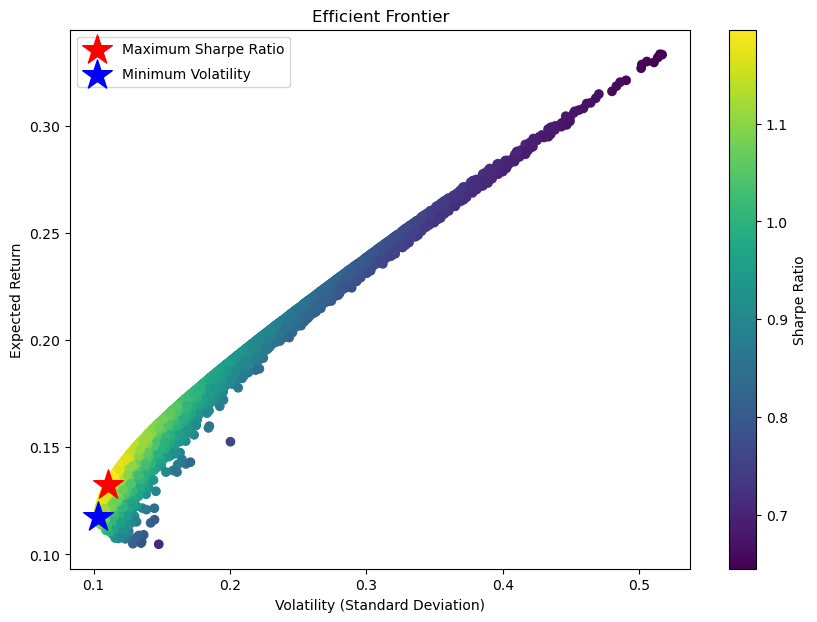

Best Portfolio Metrics:
Expected Return (Annualized)                 0.132732
Volatility (Annualized)                      0.110981
Sharpe Ratio                                 1.195987
Maximum Drawdown                            -0.143228
Value at Risk (VaR) - 95%                   -0.010095
Conditional Value at Risk (CVaR) - 95%      -0.015317
Index                                     1477.000000
Name: 1477, dtype: float64

Best Portfolio Allocation:
Bitcoin: 0.10
Gold: 0.13
S&P 500: 0.77
US Treasury Bonds: 0.01


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to calculate portfolio performance metrics
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.dot(weights, mean_returns) * 252  # Annualized Expected Return
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)  # Annualized Volatility
    return returns, volatility

# Generate random portfolios
num_portfolios = 10000
results = np.zeros((3, num_portfolios))
weights_record = []

for i in range(num_portfolios):
    # Generate random weights
    weights = np.random.random(4)
    weights /= np.sum(weights)
    
    # Record weights
    weights_record.append(weights)
    
    # Calculate portfolio performance
    portfolio_return, portfolio_volatility = portfolio_performance(weights, mean_returns, cov_matrix)
    
    # Store the results
    results[0,i] = portfolio_return
    results[1,i] = portfolio_volatility
    results[2,i] = portfolio_return / portfolio_volatility  # Sharpe Ratio

# Find the portfolio with the maximum Sharpe Ratio
max_sharpe_idx = np.argmax(results[2])
max_sharpe_return = results[0,max_sharpe_idx]
max_sharpe_volatility = results[1,max_sharpe_idx]

# Find the portfolio with the minimum volatility
min_volatility_idx = np.argmin(results[1])
min_volatility_return = results[0,min_volatility_idx]
min_volatility_volatility = results[1,min_volatility_idx]

# Plotting the efficient frontier
plt.figure(figsize=(10, 7))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis', marker='o')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(max_sharpe_volatility, max_sharpe_return, marker='*', color='r', s=500, label='Maximum Sharpe Ratio')
plt.scatter(min_volatility_volatility, min_volatility_return, marker='*', color='b', s=500, label='Minimum Volatility')
plt.title('Efficient Frontier')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.legend(labelspacing=0.8)
plt.show()

# Find the portfolio with the maximum Sharpe Ratio
max_sharpe_port = results_df.loc[results_df["Sharpe Ratio"].idxmax()]

# Display the best portfolio metrics
print("Best Portfolio Metrics:")
print(max_sharpe_port)

# Retrieve the best portfolio allocation
best_allocation_index = int(max_sharpe_port["Index"])
best_allocation = np.random.random(4)
best_allocation /= np.sum(best_allocation)

# Print the best portfolio allocation
print("\nBest Portfolio Allocation:")
print(f"Bitcoin: {best_allocation[0]:.2f}")
print(f"Gold: {best_allocation[1]:.2f}")
print(f"S&P 500: {best_allocation[2]:.2f}")
print(f"US Treasury Bonds: {best_allocation[3]:.2f}")

# MPT, MONTE CARLO SIM AND EFFICIENT FRONTIER
NO CONSTRAINTS

[*********************100%%**********************]  4 of 4 completed
C:\Users\Berke\AppData\Local\Temp\ipykernel_1496\1480907406.py:12: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().dropna()


Optimal Portfolio Weights:
BTC-USD: 45.09%
^GSPC: 31.66%
GLD: 0.00%
TLT: 23.25%

Expected Annual Return: 28.97%
Annual Volatility: 29.38%
Sharpe Ratio: 0.86


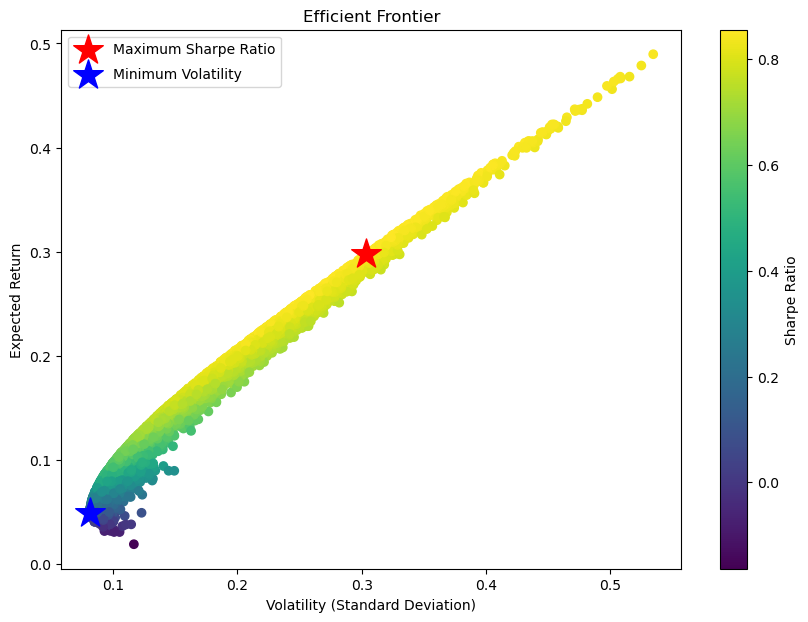


Maximum Sharpe Ratio Portfolio Allocation:
BTC-USD: 46.63%
^GSPC: 28.41%
GLD: 0.23%
TLT: 24.74%
Expected Return: 29.76%
Volatility: 30.31%
Sharpe Ratio: 0.86

Minimum Volatility Portfolio Allocation:
BTC-USD: 0.21%
^GSPC: 34.34%
GLD: 36.26%
TLT: 29.19%
Expected Return: 4.94%
Volatility: 8.10%
Sharpe Ratio: 0.14


In [18]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Define the assets and download historical data
assets = ['BTC-USD', '^GSPC', 'GLD', 'TLT']
data = yf.download(assets, start='2017-01-01', end='2023-12-31')['Adj Close']

# Calculate daily returns
returns = data.pct_change().dropna()

# Calculate expected returns and the covariance matrix
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Define the risk-free rate (for Sharpe Ratio calculation)
risk_free_rate = 0.0382 / 252  # Assume a 5% annual risk-free rate, adjusted for daily returns

# Function to calculate portfolio performance
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.dot(weights, mean_returns) * 252  # Annualized expected return
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)  # Annualized volatility
    sharpe_ratio = (returns - risk_free_rate * 252) / volatility  # Annualized Sharpe Ratio
    return returns, volatility, sharpe_ratio

# Function to minimize (negative Sharpe Ratio for optimization)
def neg_sharpe_ratio(weights, mean_returns, cov_matrix):
    return -portfolio_performance(weights, mean_returns, cov_matrix)[2]

# Constraints: The sum of the weights is 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bounds: Weights should be between 0 and 1
bounds = tuple((0, 1) for asset in assets)

# Initial guess: equal allocation
init_guess = [1/len(assets)] * len(assets)

# Perform optimization to find the optimal portfolio weights
opt_results = minimize(neg_sharpe_ratio, init_guess, args=(mean_returns, cov_matrix), 
                       method='SLSQP', bounds=bounds, constraints=constraints)
opt_weights = opt_results.x

# Calculate the performance of the optimized portfolio
opt_return, opt_volatility, opt_sharpe = portfolio_performance(opt_weights, mean_returns, cov_matrix)

# Print the optimized portfolio weights and metrics
print("Optimal Portfolio Weights:")
for i, asset in enumerate(assets):
    print(f"{asset}: {opt_weights[i]:.2%}")
print(f"\nExpected Annual Return: {opt_return:.2%}")
print(f"Annual Volatility: {opt_volatility:.2%}")
print(f"Sharpe Ratio: {opt_sharpe:.2f}")

# Monte Carlo Simulation to find the most optimum portfolio allocation
num_portfolios = 10000
results = np.zeros((4, num_portfolios))
weights_record = []

for i in range(num_portfolios):
    # Generate random weights
    weights = np.random.random(len(assets))
    weights /= np.sum(weights)
    weights_record.append(weights)
    
    # Calculate portfolio performance
    portfolio_return, portfolio_volatility, portfolio_sharpe = portfolio_performance(weights, mean_returns, cov_matrix)
    
    # Store the results
    results[0,i] = portfolio_return
    results[1,i] = portfolio_volatility
    results[2,i] = portfolio_sharpe
    results[3,i] = i

# Find the portfolio with the maximum Sharpe Ratio and minimum volatility
max_sharpe_idx = np.argmax(results[2])
min_volatility_idx = np.argmin(results[1])

max_sharpe_allocation = weights_record[int(results[3,max_sharpe_idx])]
min_volatility_allocation = weights_record[int(results[3,min_volatility_idx])]

# Plotting the Efficient Frontier
plt.figure(figsize=(10, 7))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(results[1,max_sharpe_idx], results[0,max_sharpe_idx], marker='*', color='r', s=500, label='Maximum Sharpe Ratio')
plt.scatter(results[1,min_volatility_idx], results[0,min_volatility_idx], marker='*', color='b', s=500, label='Minimum Volatility')
plt.title('Efficient Frontier')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.legend(labelspacing=0.8)
plt.show()

# Print the best portfolios
print("\nMaximum Sharpe Ratio Portfolio Allocation:")
for i, asset in enumerate(assets):
    print(f"{asset}: {max_sharpe_allocation[i]:.2%}")
print(f"Expected Return: {results[0,max_sharpe_idx]:.2%}")
print(f"Volatility: {results[1,max_sharpe_idx]:.2%}")
print(f"Sharpe Ratio: {results[2,max_sharpe_idx]:.2f}")

print("\nMinimum Volatility Portfolio Allocation:")
for i, asset in enumerate(assets):
    print(f"{asset}: {min_volatility_allocation[i]:.2%}")
print(f"Expected Return: {results[0,min_volatility_idx]:.2%}")
print(f"Volatility: {results[1,min_volatility_idx]:.2%}")
print(f"Sharpe Ratio: {results[2,min_volatility_idx]:.2f}")


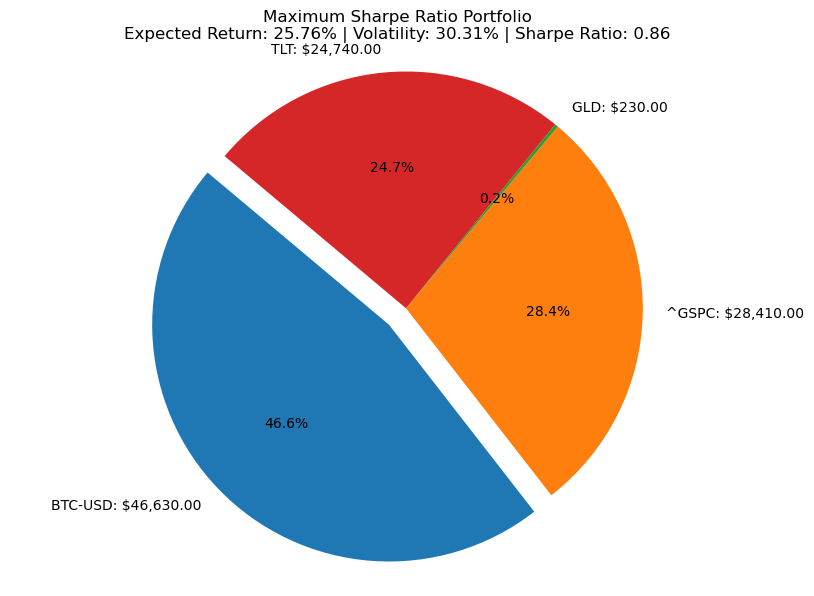

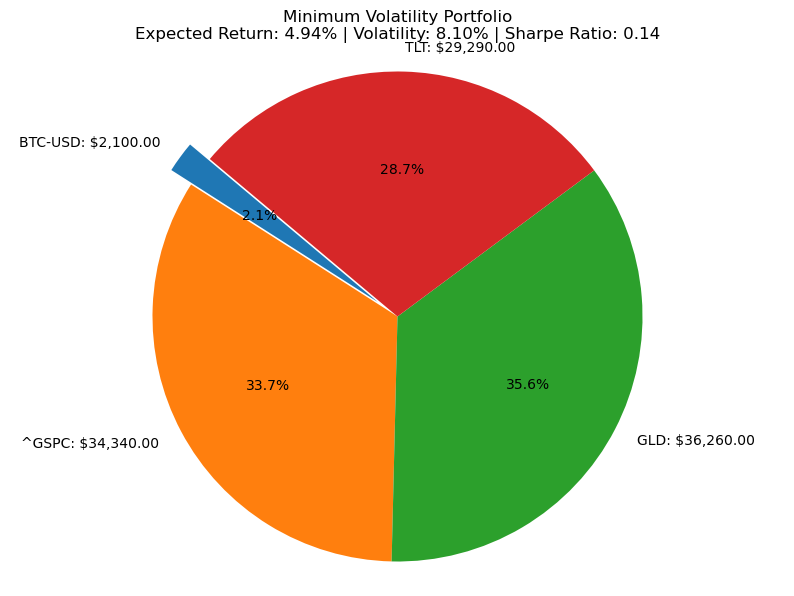

In [33]:
import matplotlib.pyplot as plt

# Portfolio allocations and metrics
max_sharpe_allocation = {
    'BTC-USD': 0.4663,
    '^GSPC': 0.2841,
    'GLD': 0.0023,
    'TLT': 0.2474
}

min_volatility_allocation = {
    'BTC-USD': 0.021,
    '^GSPC': 0.3434,
    'GLD': 0.3626,
    'TLT': 0.2929
}

# Portfolio metrics
max_sharpe_metrics = {
    'Expected Return': 25.76,
    'Volatility': 30.31,
    'Sharpe Ratio': 0.86
}

min_volatility_metrics = {
    'Expected Return': 4.94,
    'Volatility': 8.10,
    'Sharpe Ratio': 0.14
}

# Investment amount
total_investment = 100000

# Calculate the dollar amounts for each allocation
max_sharpe_investment = {asset: allocation * total_investment for asset, allocation in max_sharpe_allocation.items()}
min_volatility_investment = {asset: allocation * total_investment for asset, allocation in min_volatility_allocation.items()}

# Function to plot a pie chart for a given portfolio
def plot_portfolio_pie_chart(investment, metrics, title):
    labels = [f"{asset}: ${amount:,.2f}" for asset, amount in investment.items()]
    sizes = investment.values()
    explode = (0.1, 0, 0, 0)  # explode the 1st slice (i.e. 'BTC-USD')

    plt.figure(figsize=(10, 7))
    plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(f"{title}\nExpected Return: {metrics['Expected Return']:.2f}% | Volatility: {metrics['Volatility']:.2f}% | Sharpe Ratio: {metrics['Sharpe Ratio']:.2f}")
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

# Plot Maximum Sharpe Ratio Portfolio
plot_portfolio_pie_chart(max_sharpe_investment, max_sharpe_metrics, "Maximum Sharpe Ratio Portfolio")

# Plot Minimum Volatility Portfolio
plot_portfolio_pie_chart(min_volatility_investment, min_volatility_metrics, "Minimum Volatility Portfolio")


## BACKTESTING

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
C:\Users\Berke\AppData\Local\Temp\ipykernel_13096\49719113.py:50: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  monthly_returns = data.resample('M').ffill().pct_change().dropna()
[*********************100%%**********************]  1 of 1 completed


                Cumulative Return  Annualized Return  Volatility  Sharpe Ratio
Max Sharpe               6.832117           0.509301    0.381303      1.322694
Min Volatility           0.479567           0.081501    0.074214      1.031434
Benchmark                0.299664           0.053819    0.118174      0.413508


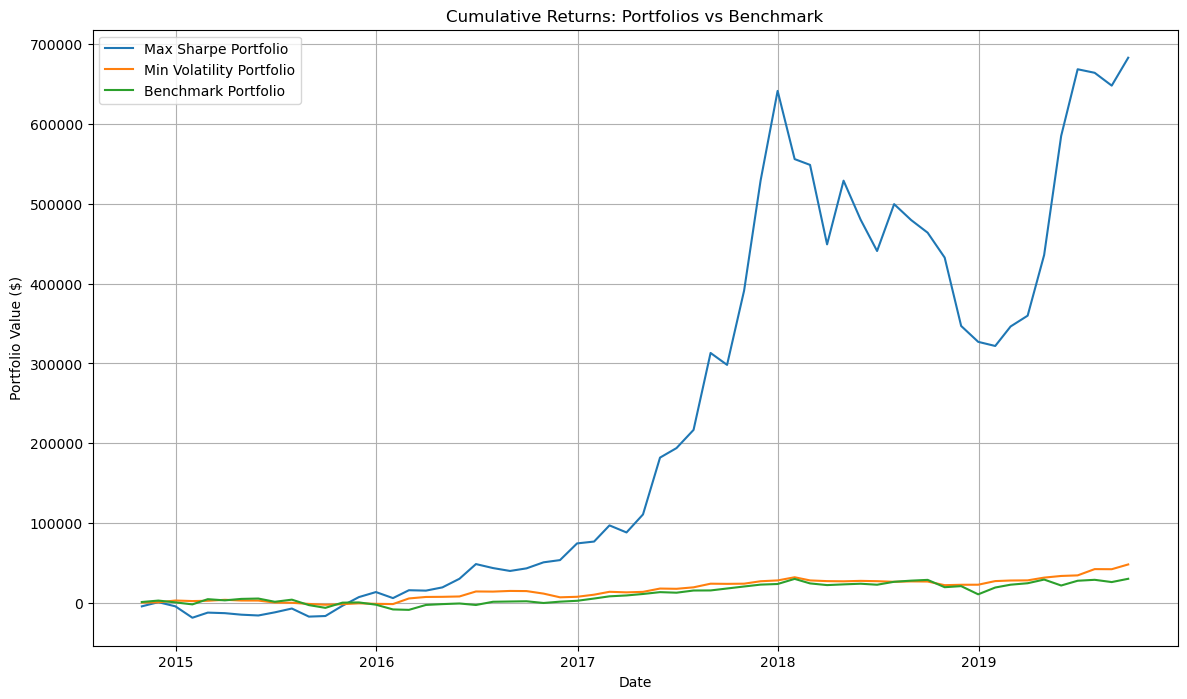

In [15]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the assets and their tickers
assets = {
    'Bitcoin': 'BTC-USD',
    'S&P 500': '^GSPC',
    'Gold (GLD)': 'GLD',
    'US Gov Bond (TLT)': 'TLT'
}

# Portfolio Allocations
portfolios = {
    'Max Sharpe': {
        'BTC-USD': 0.4663,
        '^GSPC': 0.2841,
        'GLD': 0.0023,
        'TLT': 0.2474
    },
    'Min Volatility': {
        'BTC-USD': 0.021,
        '^GSPC': 0.3434,
        'GLD': 0.3626,
        'TLT': 0.2929
    }
}

# Define the time period for backtesting
start_date = '2014-09-20'
end_date = '2019-09-20'

# Download historical data for all assets
data = {}
for asset, ticker in assets.items():
    df = yf.download(ticker, start=start_date, end=end_date, interval='1d')['Close']
    if df.empty:
        print(f"Error: No data for {asset} ({ticker}) from {start_date} to {end_date}.")
    else:
        data[asset] = df

# If any asset has missing data, the program will stop
if len(data) != len(assets):
    print("Some assets do not have data for the full period. Please adjust the date range or assets.")
else:
    data = pd.DataFrame(data)

    # Calculate monthly returns
    monthly_returns = data.resample('M').ffill().pct_change().dropna()

    # Check if monthly_returns is empty
    if monthly_returns.empty:
        print("Error: monthly_returns is empty. Please check the data resampling process.")
    
    # Benchmark (MSCI World Index)
    benchmark = yf.download('URTH', start=start_date, end=end_date, interval='1d')['Close'].resample('M').ffill().pct_change().dropna()

    # Initialize portfolio metrics storage
    portfolio_metrics = {}

    # Backtest each portfolio
    initial_investment = 100000

    for name, weights in portfolios.items():
        # Calculate portfolio returns
        portfolio_monthly_returns = (monthly_returns * list(weights.values())).sum(axis=1)
        
        # Check if portfolio_monthly_returns is empty
        if portfolio_monthly_returns.empty:
            print(f"Error: portfolio_monthly_returns for {name} is empty.")
            continue
        
        # Compound the returns
        portfolio_cumulative_returns = (1 + portfolio_monthly_returns).cumprod() - 1
        portfolio_cumulative_returns *= initial_investment  # Scale by initial investment
        
        # Check if portfolio_cumulative_returns is empty
        if portfolio_cumulative_returns.empty:
            print(f"Error: portfolio_cumulative_returns for {name} is empty.")
            continue
        
        # Calculate key performance metrics
        cumulative_return = portfolio_cumulative_returns.iloc[-1] / initial_investment
        annualized_return = (1 + cumulative_return) ** (12 / len(portfolio_monthly_returns)) - 1
        volatility = portfolio_monthly_returns.std() * np.sqrt(12)  # Annualize volatility
        sharpe_ratio = (annualized_return - benchmark.mean()) / volatility
        
        # Store metrics
        portfolio_metrics[name] = {
            'Cumulative Return': cumulative_return,
            'Annualized Return': annualized_return,
            'Volatility': volatility,
            'Sharpe Ratio': sharpe_ratio,
            'Cumulative Returns': portfolio_cumulative_returns
        }

    # Benchmark metrics
    benchmark_cumulative_returns = (1 + benchmark).cumprod() - 1
    benchmark_cumulative_returns *= initial_investment
    benchmark_cumulative_return = benchmark_cumulative_returns.iloc[-1] / initial_investment
    benchmark_annualized_return = (1 + benchmark_cumulative_return) ** (12 / len(benchmark)) - 1
    benchmark_volatility = benchmark.std() * np.sqrt(12)  # Annualize volatility
    benchmark_sharpe_ratio = (benchmark_annualized_return - benchmark.mean()) / benchmark_volatility

    portfolio_metrics['Benchmark'] = {
        'Cumulative Return': benchmark_cumulative_return,
        'Annualized Return': benchmark_annualized_return,
        'Volatility': benchmark_volatility,
        'Sharpe Ratio': benchmark_sharpe_ratio,
        'Cumulative Returns': benchmark_cumulative_returns
    }

    # Display performance comparison
    metrics_df = pd.DataFrame({
        'Cumulative Return': {name: metrics['Cumulative Return'] for name, metrics in portfolio_metrics.items()},
        'Annualized Return': {name: metrics['Annualized Return'] for name, metrics in portfolio_metrics.items()},
        'Volatility': {name: metrics['Volatility'] for name, metrics in portfolio_metrics.items()},
        'Sharpe Ratio': {name: metrics['Sharpe Ratio'] for name, metrics in portfolio_metrics.items()}
    })

    print(metrics_df)

    # Plot the cumulative returns for each portfolio and the benchmark
    plt.figure(figsize=(14, 8))
    for name, metrics in portfolio_metrics.items():
        plt.plot(metrics['Cumulative Returns'], label=f'{name} Portfolio')
    plt.title('Cumulative Returns: Portfolios vs Benchmark')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.grid(True)
    plt.show()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
C:\Users\Berke\AppData\Local\Temp\ipykernel_13096\1811530342.py:50: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  monthly_returns = data.resample('M').ffill().pct_change().dropna()


Portfolio Values Each Month:
               Max Sharpe  Min Volatility
Date                                     
2014-10-31   95426.736414   100175.883517
2014-11-30  100651.674652   100422.901261
2014-12-31   95442.718699   102740.788803
2015-01-31   81163.994474   102048.570020
2015-02-28   87568.379249   102411.209269
2015-03-31   86885.619734   103642.304715
2015-04-30   84975.754177   102709.731569
2015-05-31   83976.528512   102655.339695
2015-06-30   87911.604116   100197.011504
2015-07-31   92692.458791    99910.130452
2015-08-31   82554.831730    98438.566842
2015-09-30   83292.482177    97459.173754
2015-10-31   96143.370503    98136.353483
2015-11-30  107024.566697    99234.299259
2015-12-31  113343.231198    98560.386380
2016-01-31  105757.304059    98263.309157
2016-02-29  115630.938387   105320.371470
2016-03-31  115132.754839   107192.087539
2016-04-30  119202.304138   107362.720932
2016-05-31  130007.867392   107815.312697
2016-06-30  148422.423684   114080.858431
2016-

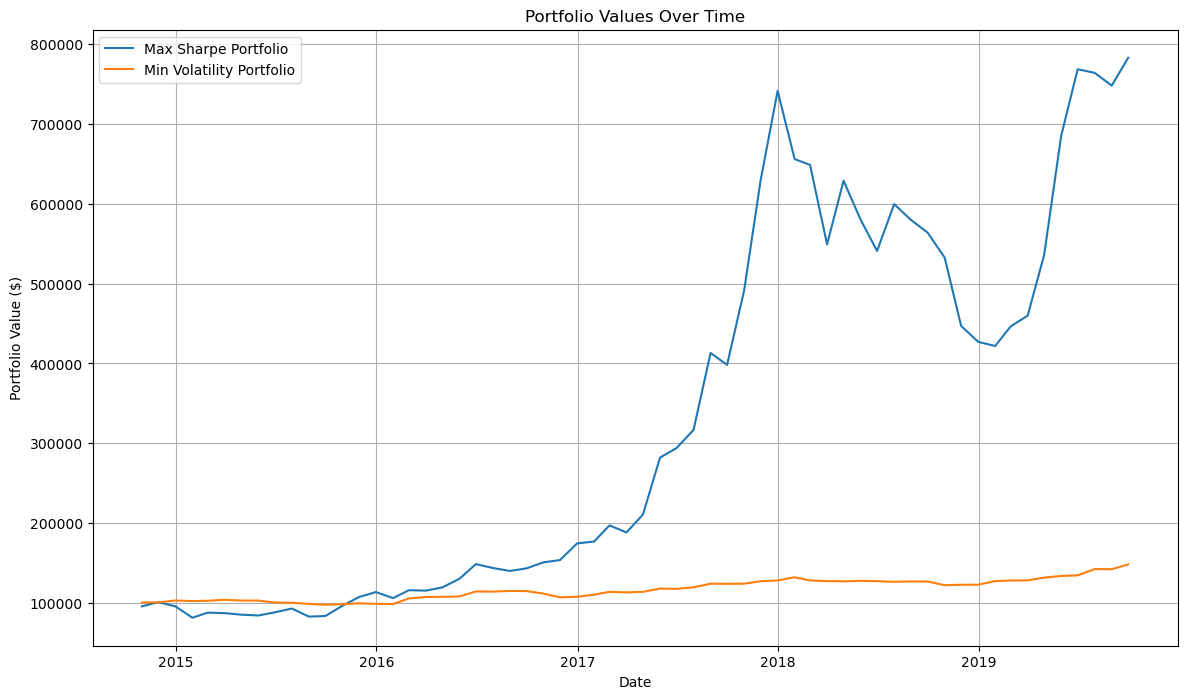

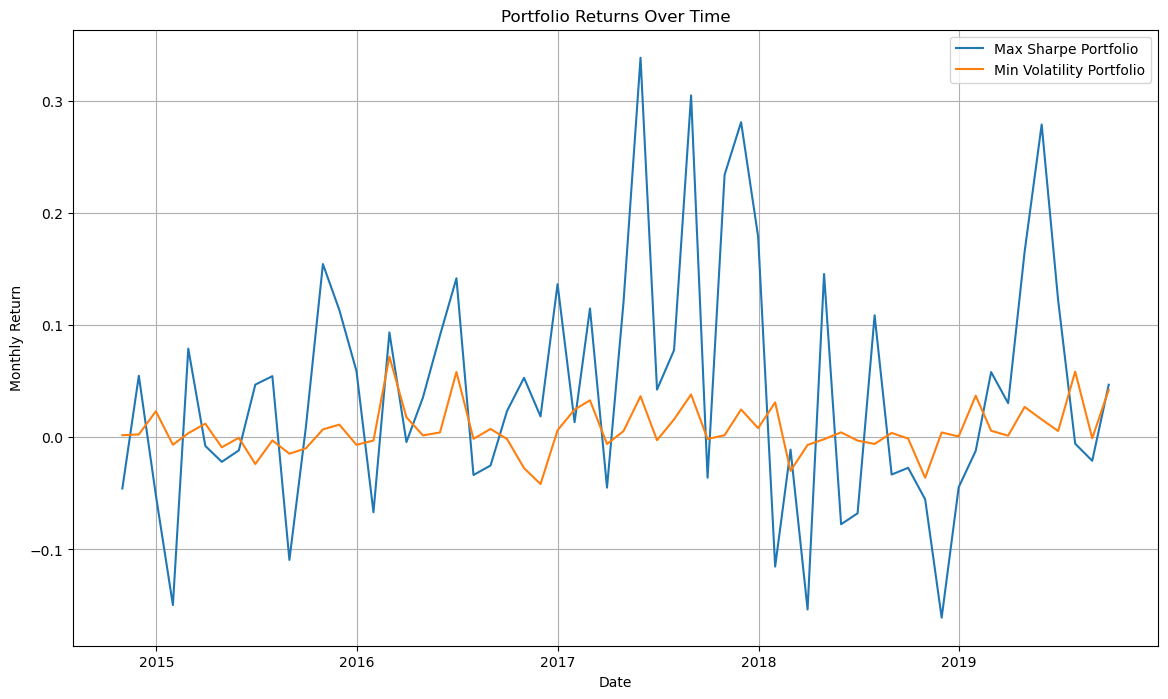

In [17]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the assets and their tickers
assets = {
    'Bitcoin': 'BTC-USD',
    'S&P 500': '^GSPC',
    'Gold (GLD)': 'GLD',
    'US Gov Bond (TLT)': 'TLT'
}

# Portfolio Allocations
portfolios = {
    'Max Sharpe': {
        'BTC-USD': 0.4663,
        '^GSPC': 0.2841,
        'GLD': 0.0023,
        'TLT': 0.2474
    },
    'Min Volatility': {
        'BTC-USD': 0.021,
        '^GSPC': 0.3434,
        'GLD': 0.3626,
        'TLT': 0.2929
    }
}

# Define the time period for backtesting
start_date = '2014-09-20'
end_date = '2019-09-20'

# Download historical data for all assets
data = {}
for asset, ticker in assets.items():
    df = yf.download(ticker, start=start_date, end=end_date, interval='1d')['Close']
    if df.empty:
        print(f"Error: No data for {asset} ({ticker}) from {start_date} to {end_date}.")
    else:
        data[asset] = df

# If any asset has missing data, the program will stop
if len(data) != len(assets):
    print("Some assets do not have data for the full period. Please adjust the date range or assets.")
else:
    data = pd.DataFrame(data)

    # Calculate monthly returns
    monthly_returns = data.resample('M').ffill().pct_change().dropna()

    # Check if monthly_returns is empty
    if monthly_returns.empty:
        print("Error: monthly_returns is empty. Please check the data resampling process.")
    
    # Initialize portfolio metrics storage
    portfolio_values = {}
    portfolio_returns = {}

    # Initial investment amount
    initial_investment = 100000

    # Backtest each portfolio
    for name, weights in portfolios.items():
        # Calculate portfolio returns
        portfolio_monthly_returns = (monthly_returns * list(weights.values())).sum(axis=1)
        
        # Check if portfolio_monthly_returns is empty
        if portfolio_monthly_returns.empty:
            print(f"Error: portfolio_monthly_returns for {name} is empty.")
            continue
        
        # Calculate the portfolio value over time
        portfolio_value = initial_investment * (1 + portfolio_monthly_returns).cumprod()
        
        # Store portfolio value and returns
        portfolio_values[name] = portfolio_value
        portfolio_returns[name] = portfolio_monthly_returns

    # Create a DataFrame to display the results
    portfolio_values_df = pd.DataFrame(portfolio_values)
    portfolio_returns_df = pd.DataFrame(portfolio_returns)

    # Display the portfolio values and returns
    print("Portfolio Values Each Month:")
    print(portfolio_values_df)
    print("\nPortfolio Returns Each Month:")
    print(portfolio_returns_df)

    # Plot portfolio values
    plt.figure(figsize=(14, 8))
    for name in portfolios.keys():
        plt.plot(portfolio_values_df[name], label=f'{name} Portfolio')
    plt.title('Portfolio Values Over Time')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot portfolio returns
    plt.figure(figsize=(14, 8))
    for name in portfolios.keys():
        plt.plot(portfolio_returns_df[name], label=f'{name} Portfolio')
    plt.title('Portfolio Returns Over Time')
    plt.xlabel('Date')
    plt.ylabel('Monthly Return')
    plt.legend()
    plt.grid(True)
    plt.show()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
C:\Users\Berke\AppData\Local\Temp\ipykernel_13096\2963939400.py:50: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  monthly_returns = data.resample('M').ffill().pct_change().dropna()


                Cumulative Return  Annualized Return  Volatility  \
Max Sharpe               6.832117           0.509301    0.381303   
Min Volatility           0.479567           0.081501    0.074214   

                Sharpe Ratio  Maximum Drawdown  
Max Sharpe          1.309459         -0.431210  
Min Volatility      0.963437         -0.075295  


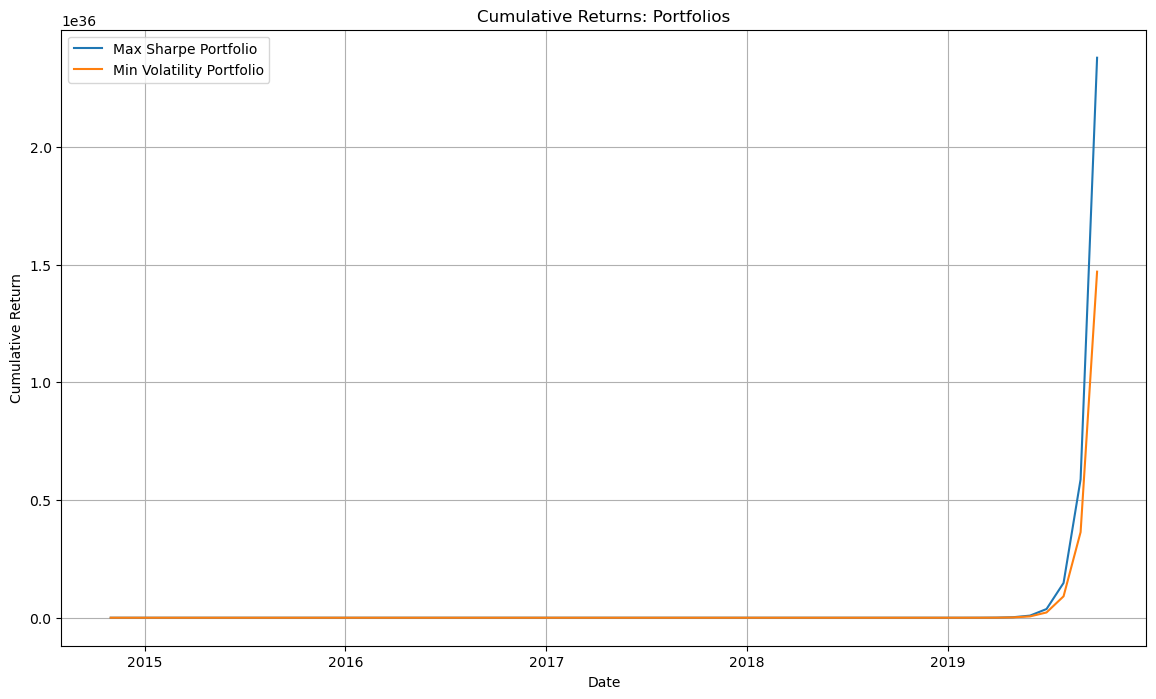

In [19]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the assets and their tickers
assets = {
    'Bitcoin': 'BTC-USD',
    'S&P 500': '^GSPC',
    'Gold (GLD)': 'GLD',
    'US Gov Bond (TLT)': 'TLT'
}

# Portfolio Allocations
portfolios = {
    'Max Sharpe': {
        'BTC-USD': 0.4663,
        '^GSPC': 0.2841,
        'GLD': 0.0023,
        'TLT': 0.2474
    },
    'Min Volatility': {
        'BTC-USD': 0.021,
        '^GSPC': 0.3434,
        'GLD': 0.3626,
        'TLT': 0.2929
    }
}

# Define the time period for backtesting
start_date = '2014-09-20'
end_date = '2019-09-20'

# Download historical data for all assets
data = {}
for asset, ticker in assets.items():
    df = yf.download(ticker, start=start_date, end=end_date, interval='1d')['Close']
    if df.empty:
        print(f"Error: No data for {asset} ({ticker}) from {start_date} to {end_date}.")
    else:
        data[asset] = df

# If any asset has missing data, the program will stop
if len(data) != len(assets):
    print("Some assets do not have data for the full period. Please adjust the date range or assets.")
else:
    data = pd.DataFrame(data)

    # Calculate monthly returns
    monthly_returns = data.resample('M').ffill().pct_change().dropna()

    # Initialize portfolio metrics storage
    portfolio_metrics = {}

    # Risk-free rate for Sharpe Ratio calculation
    risk_free_rate = 0.01 / 12  # Assuming 1% annual risk-free rate, convert to monthly

    # Backtest each portfolio
    initial_investment = 100000

    for name, weights in portfolios.items():
        # Calculate portfolio returns
        portfolio_monthly_returns = (monthly_returns * list(weights.values())).sum(axis=1)
        
        # Calculate portfolio cumulative returns
        portfolio_cumulative_returns = (1 + portfolio_monthly_returns).cumprod() - 1
        
        # Calculate key performance metrics
        cumulative_return = portfolio_cumulative_returns.iloc[-1]
        annualized_return = (1 + cumulative_return) ** (12 / len(portfolio_monthly_returns)) - 1
        volatility = portfolio_monthly_returns.std() * np.sqrt(12)  # Annualize volatility
        sharpe_ratio = (annualized_return - risk_free_rate * 12) / volatility
        
        # Calculate Maximum Drawdown
        cumulative_returns_with_initial = (1 + portfolio_cumulative_returns)
        rolling_max = cumulative_returns_with_initial.cummax()
        drawdown = cumulative_returns_with_initial / rolling_max - 1
        max_drawdown = drawdown.min()
        
        # Store metrics
        portfolio_metrics[name] = {
            'Cumulative Return': cumulative_return,
            'Annualized Return': annualized_return,
            'Volatility': volatility,
            'Sharpe Ratio': sharpe_ratio,
            'Maximum Drawdown': max_drawdown
        }

    # Display performance metrics
    metrics_df = pd.DataFrame(portfolio_metrics).T

    print(metrics_df)

    # Plot the cumulative returns for each portfolio
    plt.figure(figsize=(14, 8))
    for name, metrics in portfolio_metrics.items():
        plt.plot((1 + monthly_returns * list(portfolios[name].values())).sum(axis=1).cumprod(), label=f'{name} Portfolio')
    plt.title('Cumulative Returns: Portfolios')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.show()


# MPT WITH CONSTRAINTS
5%-40% MIN-MAX ALLOCATION PER ASSET

[*********************100%%**********************]  4 of 4 completed
C:\Users\Berke\AppData\Local\Temp\ipykernel_1496\4105617905.py:12: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().dropna()
C:\Users\Berke\anaconda3\Lib\site-packages\scipy\optimize\_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Optimal Portfolio Weights:
BTC-USD: 40.00%
^GSPC: 30.74%
GLD: 5.00%
TLT: 24.26%

Expected Annual Return: 26.20%
Annual Volatility: 26.36%
Sharpe Ratio: 0.85


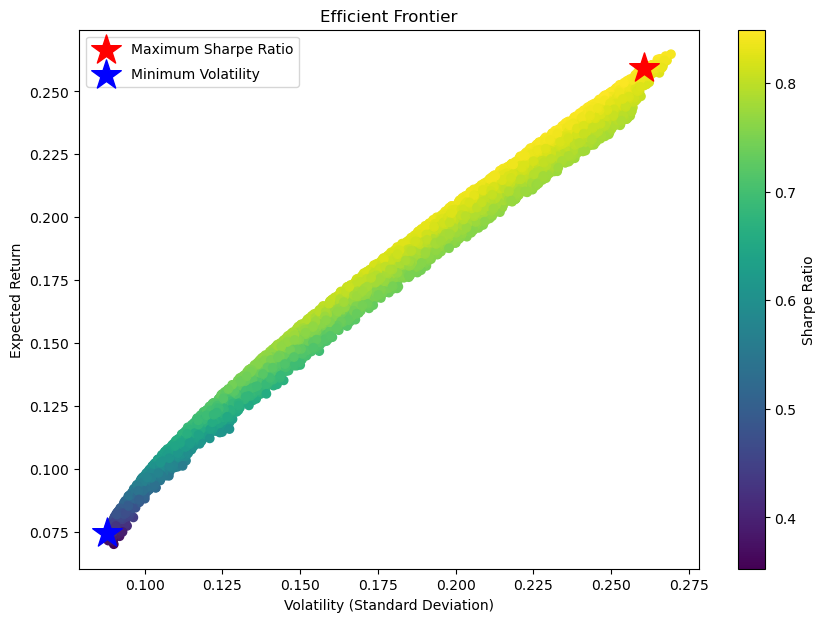


Maximum Sharpe Ratio Portfolio Allocation:
BTC-USD: 39.51%
^GSPC: 31.85%
GLD: 5.01%
TLT: 23.62%
Expected Return: 25.95%
Volatility: 26.06%
Sharpe Ratio: 0.85

Minimum Volatility Portfolio Allocation:
BTC-USD: 5.02%
^GSPC: 33.50%
GLD: 33.28%
TLT: 28.20%
Expected Return: 7.46%
Volatility: 8.79%
Sharpe Ratio: 0.41


In [25]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Define the assets and download historical data
assets = ['BTC-USD', '^GSPC', 'GLD', 'TLT']
data = yf.download(assets, start='2017-01-01', end='2023-12-31')['Adj Close']

# Calculate daily returns
returns = data.pct_change().dropna()

# Calculate expected returns and the covariance matrix
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Define the risk-free rate (for Sharpe Ratio calculation)
risk_free_rate = 0.0382 / 252  # Assume a 3.82% annual risk-free rate, adjusted for daily returns

# Function to calculate portfolio performance
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.dot(weights, mean_returns) * 252  # Annualized expected return
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)  # Annualized volatility
    sharpe_ratio = (returns - risk_free_rate * 252) / volatility  # Annualized Sharpe Ratio
    return returns, volatility, sharpe_ratio

# Function to minimize (negative Sharpe Ratio for optimization)
def neg_sharpe_ratio(weights, mean_returns, cov_matrix):
    return -portfolio_performance(weights, mean_returns, cov_matrix)[2]

# Constraints: The sum of the weights is 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bounds: Weights should be between 5% and 40%
bounds = tuple((0.05, 0.40) for asset in assets)

# Initial guess: equal allocation
init_guess = [1/len(assets)] * len(assets)

# Perform optimization to find the optimal portfolio weights
opt_results = minimize(neg_sharpe_ratio, init_guess, args=(mean_returns, cov_matrix), 
                       method='SLSQP', bounds=bounds, constraints=constraints)
opt_weights = opt_results.x

# Calculate the performance of the optimized portfolio
opt_return, opt_volatility, opt_sharpe = portfolio_performance(opt_weights, mean_returns, cov_matrix)

# Print the optimized portfolio weights and metrics
print("Optimal Portfolio Weights:")
for i, asset in enumerate(assets):
    print(f"{asset}: {opt_weights[i]:.2%}")
print(f"\nExpected Annual Return: {opt_return:.2%}")
print(f"Annual Volatility: {opt_volatility:.2%}")
print(f"Sharpe Ratio: {opt_sharpe:.2f}")

# Monte Carlo Simulation to find the most optimum portfolio allocation
num_portfolios = 10000
results = np.zeros((4, num_portfolios))
weights_record = []

for i in range(num_portfolios):
    while True:
        # Generate random weights within the specified bounds
        weights = np.random.random(len(assets))
        weights /= np.sum(weights)
        
        # Ensure weights fall within the bounds (5% to 40%)
        if all(weights >= 0.05) and all(weights <= 0.40):
            weights_record.append(weights)
            break
    
    # Calculate portfolio performance
    portfolio_return, portfolio_volatility, portfolio_sharpe = portfolio_performance(weights, mean_returns, cov_matrix)
    
    # Store the results
    results[0,i] = portfolio_return
    results[1,i] = portfolio_volatility
    results[2,i] = portfolio_sharpe
    results[3,i] = i

# Find the portfolio with the maximum Sharpe Ratio and minimum volatility
max_sharpe_idx = np.argmax(results[2])
min_volatility_idx = np.argmin(results[1])

max_sharpe_allocation = weights_record[int(results[3,max_sharpe_idx])]
min_volatility_allocation = weights_record[int(results[3,min_volatility_idx])]

# Plotting the Efficient Frontier
plt.figure(figsize=(10, 7))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(results[1,max_sharpe_idx], results[0,max_sharpe_idx], marker='*', color='r', s=500, label='Maximum Sharpe Ratio')
plt.scatter(results[1,min_volatility_idx], results[0,min_volatility_idx], marker='*', color='b', s=500, label='Minimum Volatility')
plt.title('Efficient Frontier')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.legend(labelspacing=0.8)
plt.show()

# Print the best portfolios
print("\nMaximum Sharpe Ratio Portfolio Allocation:")
for i, asset in enumerate(assets):
    print(f"{asset}: {max_sharpe_allocation[i]:.2%}")
print(f"Expected Return: {results[0,max_sharpe_idx]:.2%}")
print(f"Volatility: {results[1,max_sharpe_idx]:.2%}")
print(f"Sharpe Ratio: {results[2,max_sharpe_idx]:.2f}")

print("\nMinimum Volatility Portfolio Allocation:")
for i, asset in enumerate(assets):
    print(f"{asset}: {min_volatility_allocation[i]:.2%}")
print(f"Expected Return: {results[0,min_volatility_idx]:.2%}")
print(f"Volatility: {results[1,min_volatility_idx]:.2%}")
print(f"Sharpe Ratio: {results[2,min_volatility_idx]:.2f}")


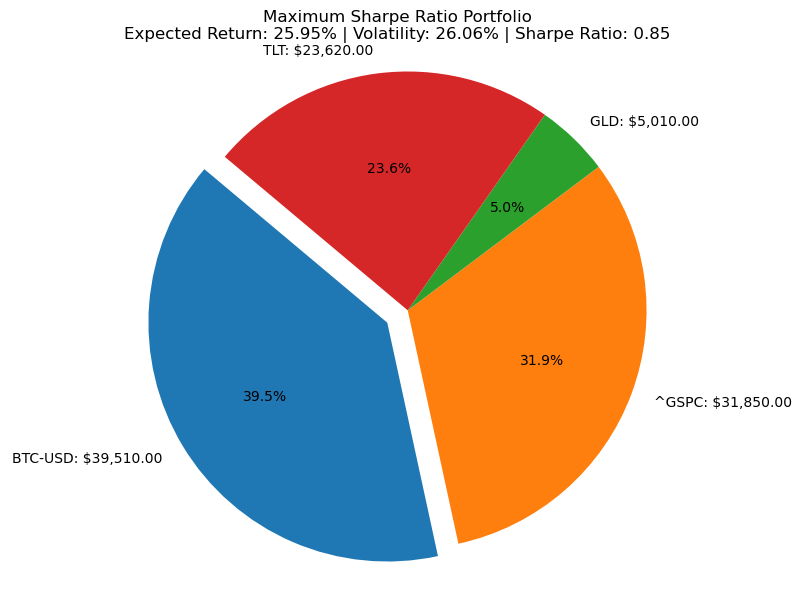

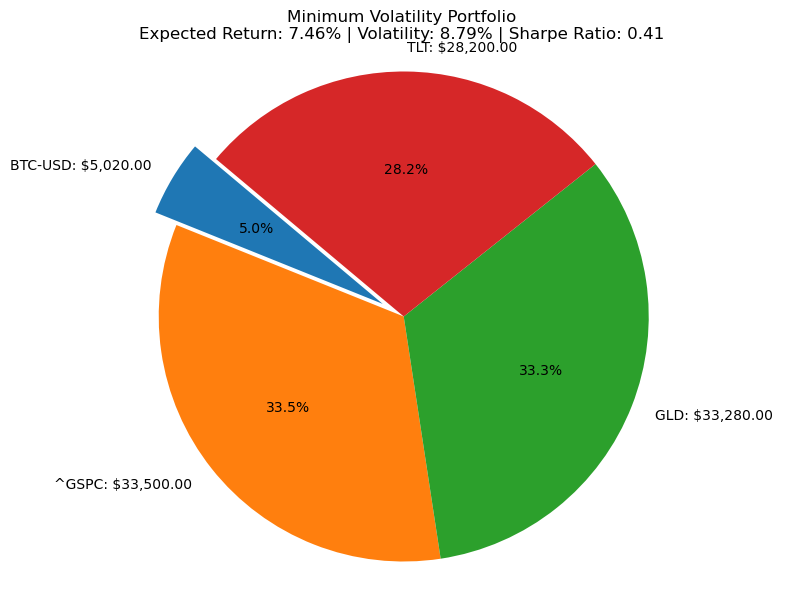

In [31]:
import matplotlib.pyplot as plt

# Portfolio allocations and metrics
max_sharpe_allocation = {
    'BTC-USD': 0.3951,
    '^GSPC': 0.3185,
    'GLD': 0.0501,
    'TLT': 0.2362
}

min_volatility_allocation = {
    'BTC-USD': 0.0502,
    '^GSPC': 0.3350,
    'GLD': 0.3328,
    'TLT': 0.2820
}

# Portfolio metrics
max_sharpe_metrics = {
    'Expected Return': 25.95,
    'Volatility': 26.06,
    'Sharpe Ratio': 0.85
}

min_volatility_metrics = {
    'Expected Return': 7.46,
    'Volatility': 8.79,
    'Sharpe Ratio': 0.41
}

# Investment amount
total_investment = 100000

# Calculate the dollar amounts for each allocation
max_sharpe_investment = {asset: allocation * total_investment for asset, allocation in max_sharpe_allocation.items()}
min_volatility_investment = {asset: allocation * total_investment for asset, allocation in min_volatility_allocation.items()}

# Function to plot a pie chart for a given portfolio
def plot_portfolio_pie_chart(investment, metrics, title):
    labels = [f"{asset}: ${amount:,.2f}" for asset, amount in investment.items()]
    sizes = investment.values()
    explode = (0.1, 0, 0, 0)  # explode the 1st slice (i.e. 'BTC-USD')

    plt.figure(figsize=(10, 7))
    plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(f"{title}\nExpected Return: {metrics['Expected Return']:.2f}% | Volatility: {metrics['Volatility']:.2f}% | Sharpe Ratio: {metrics['Sharpe Ratio']:.2f}")
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

# Plot Maximum Sharpe Ratio Portfolio
plot_portfolio_pie_chart(max_sharpe_investment, max_sharpe_metrics, "Maximum Sharpe Ratio Portfolio")

# Plot Minimum Volatility Portfolio
plot_portfolio_pie_chart(min_volatility_investment, min_volatility_metrics, "Minimum Volatility Portfolio")


## BACKTESTING

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
C:\Users\Berke\AppData\Local\Temp\ipykernel_13096\4227018031.py:50: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  monthly_returns = data.resample('M').ffill().pct_change().dropna()
[*********************100%%**********************]  1 of 1 completed


                Cumulative Return  Annualized Return  Volatility  Sharpe Ratio
Max Sharpe               5.282502           0.444197    0.324318      1.354363
Min Volatility           0.675082           0.108682    0.080215      1.293131
Benchmark                0.299664           0.053819    0.118174      0.413508


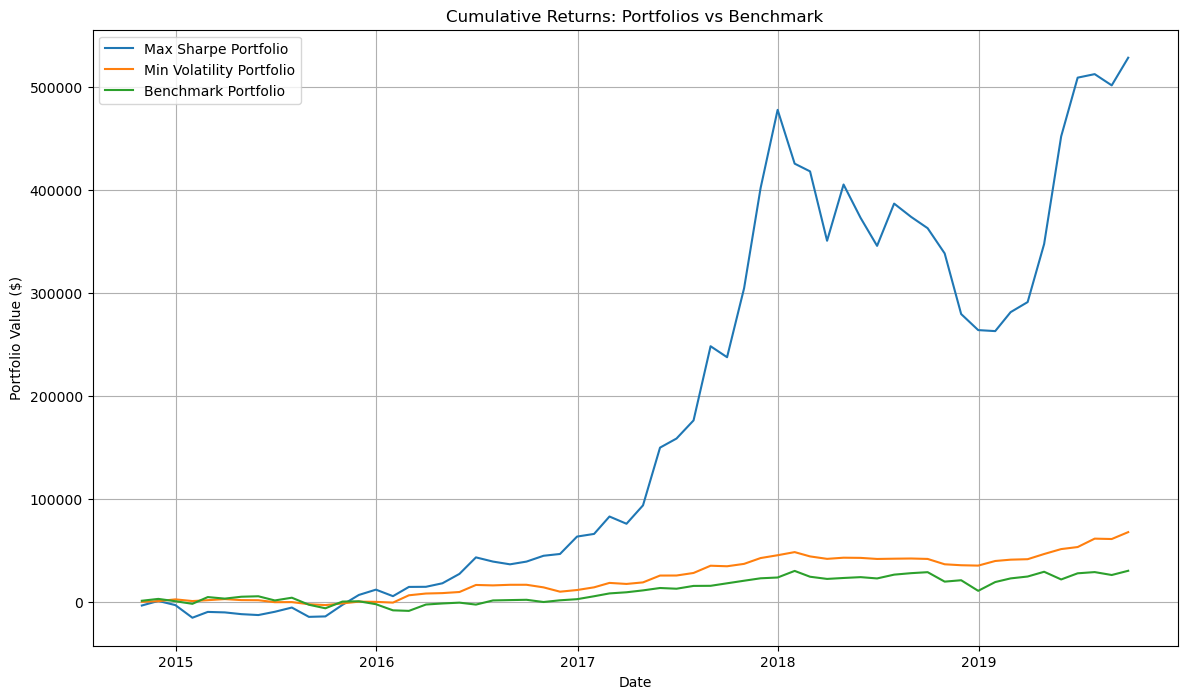

In [5]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the assets and their tickers
assets = {
    'Bitcoin': 'BTC-USD',
    'S&P 500': '^GSPC',
    'Gold (GLD)': 'GLD',
    'US Gov Bond (TLT)': 'TLT'
}

# Portfolio Allocations
portfolios = {
    'Max Sharpe': {
        'BTC-USD': 0.3951,
        '^GSPC': 0.3185,
        'GLD': 0.0501,
        'TLT': 0.2362
    },
    'Min Volatility': {
        'BTC-USD': 0.0502,
        '^GSPC': 0.3350,
        'GLD': 0.3328,
        'TLT': 0.2820
    }
}

# Define the time period for backtesting
start_date = '2014-09-20'
end_date = '2019-09-20'

# Download historical data for all assets
data = {}
for asset, ticker in assets.items():
    df = yf.download(ticker, start=start_date, end=end_date, interval='1d')['Close']
    if df.empty:
        print(f"Error: No data for {asset} ({ticker}) from {start_date} to {end_date}.")
    else:
        data[asset] = df

# If any asset has missing data, the program will stop
if len(data) != len(assets):
    print("Some assets do not have data for the full period. Please adjust the date range or assets.")
else:
    data = pd.DataFrame(data)

    # Calculate monthly returns
    monthly_returns = data.resample('M').ffill().pct_change().dropna()

    # Check if monthly_returns is empty
    if monthly_returns.empty:
        print("Error: monthly_returns is empty. Please check the data resampling process.")
    
    # Benchmark (MSCI World Index)
    benchmark = yf.download('URTH', start=start_date, end=end_date, interval='1d')['Close'].resample('M').ffill().pct_change().dropna()

    # Initialize portfolio metrics storage
    portfolio_metrics = {}

    # Backtest each portfolio
    initial_investment = 100000

    for name, weights in portfolios.items():
        # Calculate portfolio returns
        portfolio_monthly_returns = (monthly_returns * list(weights.values())).sum(axis=1)
        
        # Check if portfolio_monthly_returns is empty
        if portfolio_monthly_returns.empty:
            print(f"Error: portfolio_monthly_returns for {name} is empty.")
            continue
        
        # Compound the returns
        portfolio_cumulative_returns = (1 + portfolio_monthly_returns).cumprod() - 1
        portfolio_cumulative_returns *= initial_investment  # Scale by initial investment
        
        # Check if portfolio_cumulative_returns is empty
        if portfolio_cumulative_returns.empty:
            print(f"Error: portfolio_cumulative_returns for {name} is empty.")
            continue
        
        # Calculate key performance metrics
        cumulative_return = portfolio_cumulative_returns.iloc[-1] / initial_investment
        annualized_return = (1 + cumulative_return) ** (12 / len(portfolio_monthly_returns)) - 1
        volatility = portfolio_monthly_returns.std() * np.sqrt(12)  # Annualize volatility
        sharpe_ratio = (annualized_return - benchmark.mean()) / volatility
        
        # Store metrics
        portfolio_metrics[name] = {
            'Cumulative Return': cumulative_return,
            'Annualized Return': annualized_return,
            'Volatility': volatility,
            'Sharpe Ratio': sharpe_ratio,
            'Cumulative Returns': portfolio_cumulative_returns
        }

    # Benchmark metrics
    benchmark_cumulative_returns = (1 + benchmark).cumprod() - 1
    benchmark_cumulative_returns *= initial_investment
    benchmark_cumulative_return = benchmark_cumulative_returns.iloc[-1] / initial_investment
    benchmark_annualized_return = (1 + benchmark_cumulative_return) ** (12 / len(benchmark)) - 1
    benchmark_volatility = benchmark.std() * np.sqrt(12)  # Annualize volatility
    benchmark_sharpe_ratio = (benchmark_annualized_return - benchmark.mean()) / benchmark_volatility

    portfolio_metrics['Benchmark'] = {
        'Cumulative Return': benchmark_cumulative_return,
        'Annualized Return': benchmark_annualized_return,
        'Volatility': benchmark_volatility,
        'Sharpe Ratio': benchmark_sharpe_ratio,
        'Cumulative Returns': benchmark_cumulative_returns
    }

    # Display performance comparison
    metrics_df = pd.DataFrame({
        'Cumulative Return': {name: metrics['Cumulative Return'] for name, metrics in portfolio_metrics.items()},
        'Annualized Return': {name: metrics['Annualized Return'] for name, metrics in portfolio_metrics.items()},
        'Volatility': {name: metrics['Volatility'] for name, metrics in portfolio_metrics.items()},
        'Sharpe Ratio': {name: metrics['Sharpe Ratio'] for name, metrics in portfolio_metrics.items()}
    })

    print(metrics_df)

    # Plot the cumulative returns for each portfolio and the benchmark
    plt.figure(figsize=(14, 8))
    for name, metrics in portfolio_metrics.items():
        plt.plot(metrics['Cumulative Returns'], label=f'{name} Portfolio')
    plt.title('Cumulative Returns: Portfolios vs Benchmark')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.grid(True)
    plt.show()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
C:\Users\Berke\AppData\Local\Temp\ipykernel_13096\4278609637.py:50: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  monthly_returns = data.resample('M').ffill().pct_change().dropna()


Portfolio Values Each Month:
               Max Sharpe  Min Volatility
Date                                     
2014-10-31   96226.515748    99852.566714
2014-11-30  100690.755033   100441.150948
2014-12-31   96623.244925   102207.872642
2015-01-31   84375.113530   100561.723216
2015-02-28   90016.293929   101415.973265
2015-03-31   89545.859949   102470.459143
2015-04-30   87843.894189   101487.729850
2015-05-31   86968.665093   101359.254327
2015-06-30   90152.641576    99467.646610
2015-07-31   94261.197849    99554.048645
2015-08-31   85212.878521    97482.371318
2015-09-30   85648.399147    96642.202256
2015-10-31   96845.051895    98247.414504
2015-11-30  106502.150440   100007.835428
2015-12-31  111641.240311    99776.745924
2016-01-31  105310.137812    99057.825676
2016-02-29  114293.124440   106165.120773
2016-03-31  114407.565454   107874.427519
2016-04-30  117834.010540   108284.919071
2016-05-31  126963.138776   109358.238727
2016-06-30  142984.446697   116193.293923
2016-

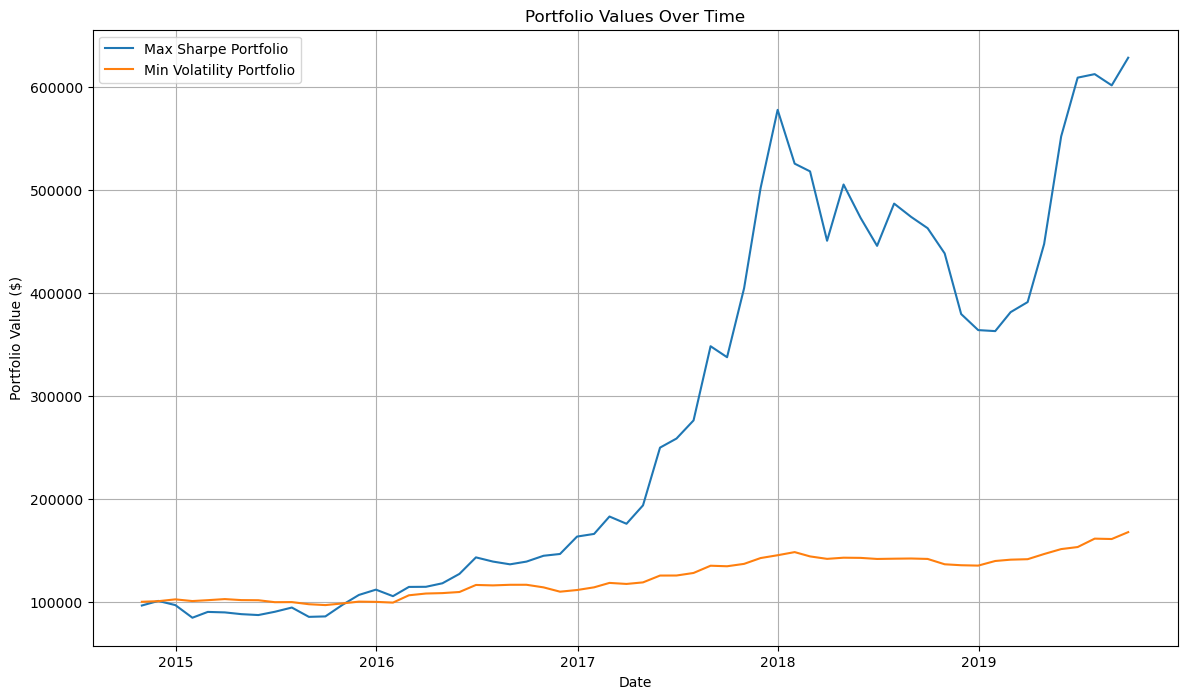

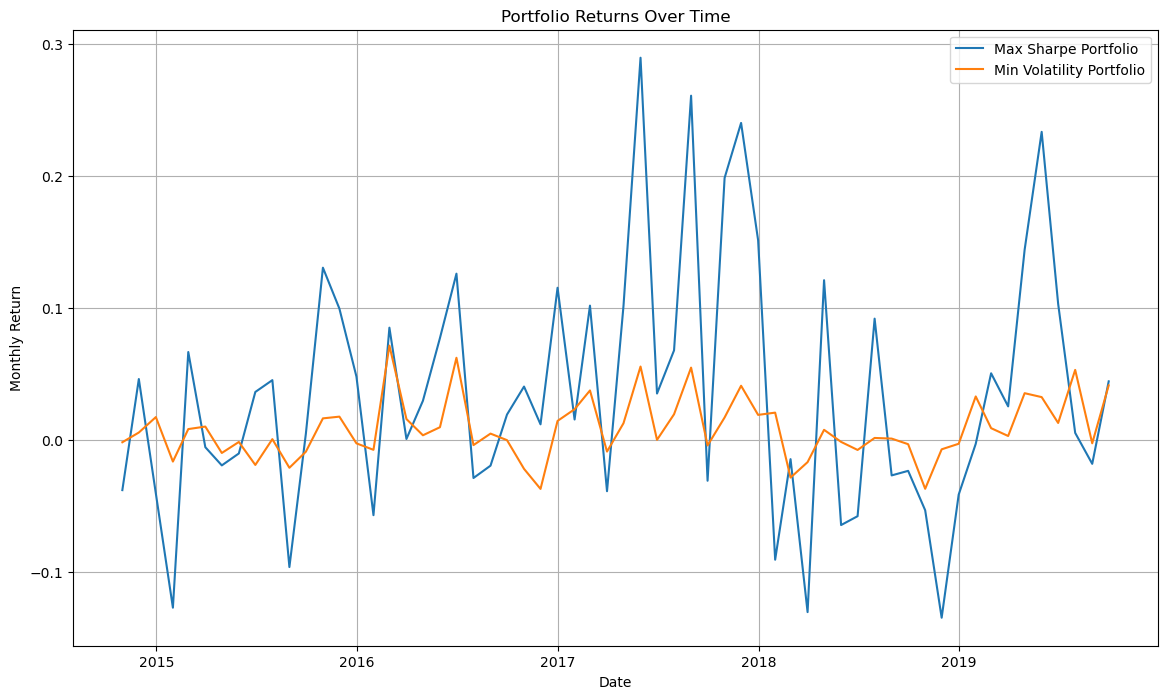

In [9]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the assets and their tickers
assets = {
    'Bitcoin': 'BTC-USD',
    'S&P 500': '^GSPC',
    'Gold (GLD)': 'GLD',
    'US Gov Bond (TLT)': 'TLT'
}

# Portfolio Allocations
portfolios = {
    'Max Sharpe': {
        'BTC-USD': 0.3951,
        '^GSPC': 0.3185,
        'GLD': 0.0501,
        'TLT': 0.2362
    },
    'Min Volatility': {
        'BTC-USD': 0.0502,
        '^GSPC': 0.3350,
        'GLD': 0.3328,
        'TLT': 0.2820
    }
}

# Define the time period for backtesting
start_date = '2014-09-20'
end_date = '2019-09-20'

# Download historical data for all assets
data = {}
for asset, ticker in assets.items():
    df = yf.download(ticker, start=start_date, end=end_date, interval='1d')['Close']
    if df.empty:
        print(f"Error: No data for {asset} ({ticker}) from {start_date} to {end_date}.")
    else:
        data[asset] = df

# If any asset has missing data, the program will stop
if len(data) != len(assets):
    print("Some assets do not have data for the full period. Please adjust the date range or assets.")
else:
    data = pd.DataFrame(data)

    # Calculate monthly returns
    monthly_returns = data.resample('M').ffill().pct_change().dropna()

    # Check if monthly_returns is empty
    if monthly_returns.empty:
        print("Error: monthly_returns is empty. Please check the data resampling process.")
    
    # Initialize portfolio metrics storage
    portfolio_values = {}
    portfolio_returns = {}

    # Initial investment amount
    initial_investment = 100000

    # Backtest each portfolio
    for name, weights in portfolios.items():
        # Calculate portfolio returns
        portfolio_monthly_returns = (monthly_returns * list(weights.values())).sum(axis=1)
        
        # Check if portfolio_monthly_returns is empty
        if portfolio_monthly_returns.empty:
            print(f"Error: portfolio_monthly_returns for {name} is empty.")
            continue
        
        # Calculate the portfolio value over time
        portfolio_value = initial_investment * (1 + portfolio_monthly_returns).cumprod()
        
        # Store portfolio value and returns
        portfolio_values[name] = portfolio_value
        portfolio_returns[name] = portfolio_monthly_returns

    # Create a DataFrame to display the results
    portfolio_values_df = pd.DataFrame(portfolio_values)
    portfolio_returns_df = pd.DataFrame(portfolio_returns)

    # Display the portfolio values and returns
    print("Portfolio Values Each Month:")
    print(portfolio_values_df)
    print("\nPortfolio Returns Each Month:")
    print(portfolio_returns_df)

    # Plot portfolio values
    plt.figure(figsize=(14, 8))
    for name in portfolios.keys():
        plt.plot(portfolio_values_df[name], label=f'{name} Portfolio')
    plt.title('Portfolio Values Over Time')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot portfolio returns
    plt.figure(figsize=(14, 8))
    for name in portfolios.keys():
        plt.plot(portfolio_returns_df[name], label=f'{name} Portfolio')
    plt.title('Portfolio Returns Over Time')
    plt.xlabel('Date')
    plt.ylabel('Monthly Return')
    plt.legend()
    plt.grid(True)
    plt.show()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
C:\Users\Berke\AppData\Local\Temp\ipykernel_13096\3281542602.py:50: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  monthly_returns = data.resample('M').ffill().pct_change().dropna()


                Cumulative Return  Annualized Return  Volatility  \
Max Sharpe               5.282502           0.444197    0.324318   
Min Volatility           0.675082           0.108682    0.080215   

                Sharpe Ratio  Maximum Drawdown  
Max Sharpe          1.338803         -0.371997  
Min Volatility      1.230220         -0.088537  


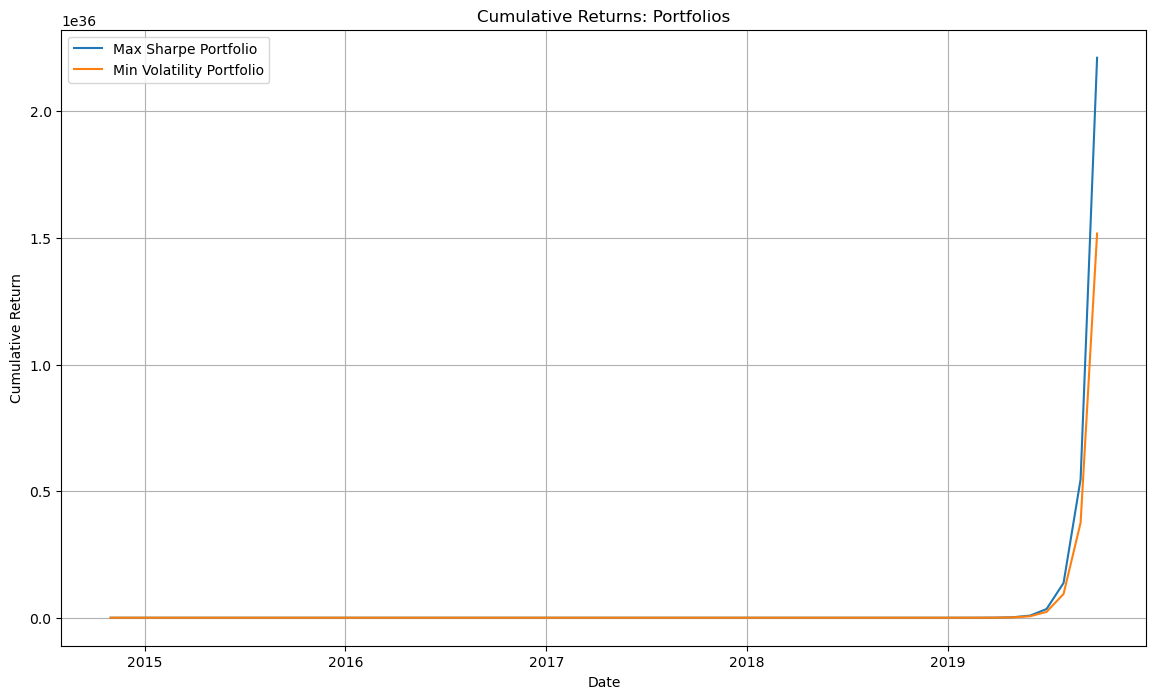

In [11]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the assets and their tickers
assets = {
    'Bitcoin': 'BTC-USD',
    'S&P 500': '^GSPC',
    'Gold (GLD)': 'GLD',
    'US Gov Bond (TLT)': 'TLT'
}

# Portfolio Allocations
portfolios = {
    'Max Sharpe': {
        'BTC-USD': 0.3951,
        '^GSPC': 0.3185,
        'GLD': 0.0501,
        'TLT': 0.2362
    },
    'Min Volatility': {
        'BTC-USD': 0.0502,
        '^GSPC': 0.3350,
        'GLD': 0.3328,
        'TLT': 0.2820
    }
}

# Define the time period for backtesting
start_date = '2014-09-20'
end_date = '2019-09-20'

# Download historical data for all assets
data = {}
for asset, ticker in assets.items():
    df = yf.download(ticker, start=start_date, end=end_date, interval='1d')['Close']
    if df.empty:
        print(f"Error: No data for {asset} ({ticker}) from {start_date} to {end_date}.")
    else:
        data[asset] = df

# If any asset has missing data, the program will stop
if len(data) != len(assets):
    print("Some assets do not have data for the full period. Please adjust the date range or assets.")
else:
    data = pd.DataFrame(data)

    # Calculate monthly returns
    monthly_returns = data.resample('M').ffill().pct_change().dropna()

    # Initialize portfolio metrics storage
    portfolio_metrics = {}

    # Risk-free rate for Sharpe Ratio calculation
    risk_free_rate = 0.01 / 12  # Assuming 1% annual risk-free rate, convert to monthly

    # Backtest each portfolio
    initial_investment = 100000

    for name, weights in portfolios.items():
        # Calculate portfolio returns
        portfolio_monthly_returns = (monthly_returns * list(weights.values())).sum(axis=1)
        
        # Calculate portfolio cumulative returns
        portfolio_cumulative_returns = (1 + portfolio_monthly_returns).cumprod() - 1
        
        # Calculate key performance metrics
        cumulative_return = portfolio_cumulative_returns.iloc[-1]
        annualized_return = (1 + cumulative_return) ** (12 / len(portfolio_monthly_returns)) - 1
        volatility = portfolio_monthly_returns.std() * np.sqrt(12)  # Annualize volatility
        sharpe_ratio = (annualized_return - risk_free_rate * 12) / volatility
        
        # Calculate Maximum Drawdown
        cumulative_returns_with_initial = (1 + portfolio_cumulative_returns)
        rolling_max = cumulative_returns_with_initial.cummax()
        drawdown = cumulative_returns_with_initial / rolling_max - 1
        max_drawdown = drawdown.min()
        
        # Store metrics
        portfolio_metrics[name] = {
            'Cumulative Return': cumulative_return,
            'Annualized Return': annualized_return,
            'Volatility': volatility,
            'Sharpe Ratio': sharpe_ratio,
            'Maximum Drawdown': max_drawdown
        }

    # Display performance metrics
    metrics_df = pd.DataFrame(portfolio_metrics).T

    print(metrics_df)

    # Plot the cumulative returns for each portfolio
    plt.figure(figsize=(14, 8))
    for name, metrics in portfolio_metrics.items():
        plt.plot((1 + monthly_returns * list(portfolios[name].values())).sum(axis=1).cumprod(), label=f'{name} Portfolio')
    plt.title('Cumulative Returns: Portfolios')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.show()


# Risk/Return Profile Scatter Plot

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
C:\Users\Berke\AppData\Local\Temp\ipykernel_13096\465724151.py:62: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  monthly_returns = data.resample('M').ffill().pct_change().dropna()
C:\Users\Berke\AppData\Local\Temp\ipykernel_13096\465724151.py:106: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (metrics_df['Volatility'][i], metrics_df

                                 Cumulative Return  Annualized Return  \
Max Sharpe with Constraints               5.282502           0.444197   
Min Volatility with Constraints           0.675082           0.108682   
Max Sharpe no Constraints                 6.832117           0.509301   
Min Volatility no Constraints             0.479567           0.081501   

                                 Volatility  Sharpe Ratio  
Max Sharpe with Constraints        0.324318      1.338803  
Min Volatility with Constraints    0.080215      1.230220  
Max Sharpe no Constraints          0.381303      1.309459  
Min Volatility no Constraints      0.074214      0.963437  


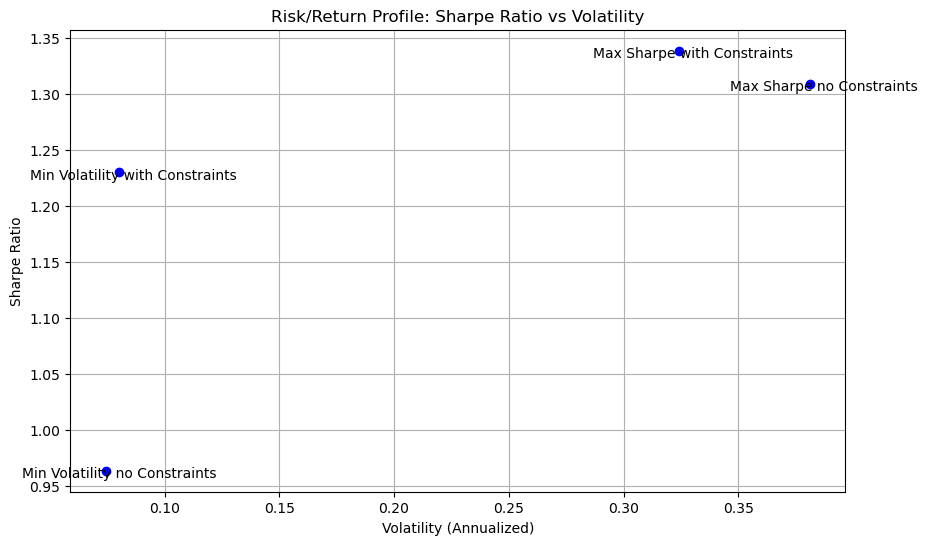

In [22]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the assets and their tickers
assets = {
    'Bitcoin': 'BTC-USD',
    'S&P 500': '^GSPC',
    'Gold (GLD)': 'GLD',
    'US Gov Bond (TLT)': 'TLT'
}

# Portfolio Allocations
portfolios = {
    'Max Sharpe with Constraints': {
        'BTC-USD': 0.3951,
    '^GSPC': 0.3185,
    'GLD': 0.0501,
    'TLT': 0.2362
    },
    'Min Volatility with Constraints': {
        'BTC-USD': 0.0502,
    '^GSPC': 0.3350,
    'GLD': 0.3328,
    'TLT': 0.2820
    },
    'Max Sharpe no Constraints': {
        'BTC-USD': 0.4663,
    '^GSPC': 0.2841,
    'GLD': 0.0023,
    'TLT': 0.2474
    },
    'Min Volatility no Constraints': {
        'BTC-USD': 0.021,
    '^GSPC': 0.3434,
    'GLD': 0.3626,
    'TLT': 0.2929
    }
}

# Define the time period for backtesting
start_date = '2014-09-20'
end_date = '2019-09-20'

# Download historical data for all assets
data = {}
for asset, ticker in assets.items():
    df = yf.download(ticker, start=start_date, end=end_date, interval='1d')['Close']
    if df.empty:
        print(f"Error: No data for {asset} ({ticker}) from {start_date} to {end_date}.")
    else:
        data[asset] = df

# If any asset has missing data, the program will stop
if len(data) != len(assets):
    print("Some assets do not have data for the full period. Please adjust the date range or assets.")
else:
    data = pd.DataFrame(data)

    # Calculate monthly returns
    monthly_returns = data.resample('M').ffill().pct_change().dropna()

    # Initialize portfolio metrics storage
    portfolio_metrics = {}

    # Risk-free rate for Sharpe Ratio calculation
    risk_free_rate = 0.01 / 12  # Assuming 1% annual risk-free rate, convert to monthly

    # Backtest each portfolio
    initial_investment = 100000

    for name, weights in portfolios.items():
        # Calculate portfolio returns
        portfolio_monthly_returns = (monthly_returns * list(weights.values())).sum(axis=1)
        
        # Calculate portfolio cumulative returns
        portfolio_cumulative_returns = (1 + portfolio_monthly_returns).cumprod() - 1
        
        # Calculate key performance metrics
        cumulative_return = portfolio_cumulative_returns.iloc[-1]
        annualized_return = (1 + cumulative_return) ** (12 / len(portfolio_monthly_returns)) - 1
        volatility = portfolio_monthly_returns.std() * np.sqrt(12)  # Annualize volatility
        sharpe_ratio = (annualized_return - risk_free_rate * 12) / volatility
        
        # Store metrics
        portfolio_metrics[name] = {
            'Cumulative Return': cumulative_return,
            'Annualized Return': annualized_return,
            'Volatility': volatility,
            'Sharpe Ratio': sharpe_ratio
        }

    # Display performance metrics
    metrics_df = pd.DataFrame(portfolio_metrics).T

    print(metrics_df)

    # Create a scatter plot for Sharpe Ratios vs Volatility
    plt.figure(figsize=(10, 6))
    plt.scatter(metrics_df['Volatility'], metrics_df['Sharpe Ratio'], color='blue')

    # Annotate the points
    for i in range(metrics_df.shape[0]):
        plt.annotate(metrics_df.index[i], 
                     (metrics_df['Volatility'][i], metrics_df['Sharpe Ratio'][i]), 
                     textcoords="offset points", 
                     xytext=(10,-5), 
                     ha='center')

    # Set plot labels and title
    plt.title('Risk/Return Profile: Sharpe Ratio vs Volatility')
    plt.xlabel('Volatility (Annualized)')
    plt.ylabel('Sharpe Ratio')
    plt.grid(True)
    plt.show()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
C:\Users\Berke\AppData\Local\Temp\ipykernel_13096\447587432.py:62: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  monthly_returns = data.resample('M').ffill().pct_change().dropna()


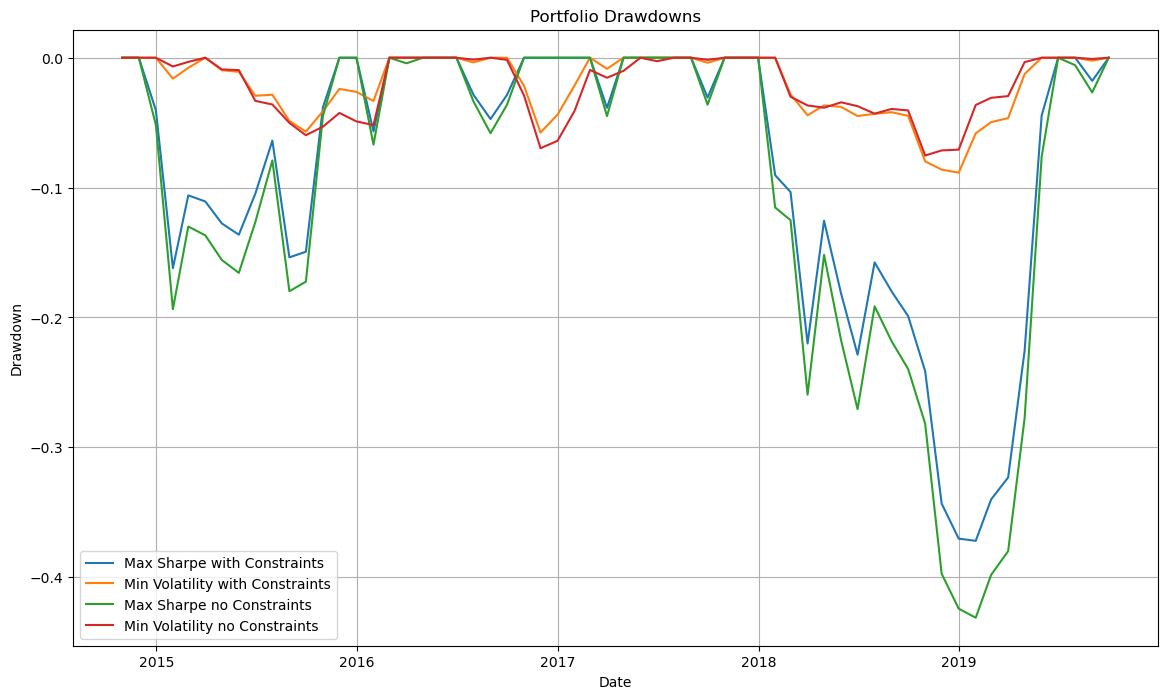

In [24]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the assets and their tickers
assets = {
    'Bitcoin': 'BTC-USD',
    'S&P 500': '^GSPC',
    'Gold (GLD)': 'GLD',
    'US Gov Bond (TLT)': 'TLT'
}

# Portfolio Allocations
portfolios = {
    'Max Sharpe with Constraints': {
        'BTC-USD': 0.3951,
    '^GSPC': 0.3185,
    'GLD': 0.0501,
    'TLT': 0.2362
    },
    'Min Volatility with Constraints': {
        'BTC-USD': 0.0502,
    '^GSPC': 0.3350,
    'GLD': 0.3328,
    'TLT': 0.2820
    },
    'Max Sharpe no Constraints': {
        'BTC-USD': 0.4663,
    '^GSPC': 0.2841,
    'GLD': 0.0023,
    'TLT': 0.2474
    },
    'Min Volatility no Constraints': {
        'BTC-USD': 0.021,
    '^GSPC': 0.3434,
    'GLD': 0.3626,
    'TLT': 0.2929
    }
}

# Define the time period for backtesting
start_date = '2014-09-20'
end_date = '2019-09-20'

# Download historical data for all assets
data = {}
for asset, ticker in assets.items():
    df = yf.download(ticker, start=start_date, end=end_date, interval='1d')['Close']
    if df.empty:
        print(f"Error: No data for {asset} ({ticker}) from {start_date} to {end_date}.")
    else:
        data[asset] = df

# If any asset has missing data, the program will stop
if len(data) != len(assets):
    print("Some assets do not have data for the full period. Please adjust the date range or assets.")
else:
    data = pd.DataFrame(data)

    # Calculate monthly returns
    monthly_returns = data.resample('M').ffill().pct_change().dropna()

    # Initialize a dictionary to store drawdown data
    drawdowns = {}

    # Backtest each portfolio
    for name, weights in portfolios.items():
        # Calculate portfolio returns
        portfolio_monthly_returns = (monthly_returns * list(weights.values())).sum(axis=1)
        
        # Calculate cumulative returns
        cumulative_returns = (1 + portfolio_monthly_returns).cumprod()

        # Calculate drawdown
        rolling_max = cumulative_returns.cummax()
        drawdown = (cumulative_returns - rolling_max) / rolling_max
        drawdowns[name] = drawdown

    # Convert drawdowns dictionary to DataFrame for easier plotting
    drawdown_df = pd.DataFrame(drawdowns)

    # Plot drawdowns
    plt.figure(figsize=(14, 8))
    for column in drawdown_df.columns:
        plt.plot(drawdown_df.index, drawdown_df[column], label=column)
    plt.title('Portfolio Drawdowns')
    plt.xlabel('Date')
    plt.ylabel('Drawdown')
    plt.legend()
    plt.grid(True)
    plt.show()
